# WorldModelV3 Diagnostics: Metrics & HI Trajectories

Evaluate a trained WorldModelV3 checkpoint on the C-MAPSS FD00x datasets using the **exact test pipeline** (feature engineering, scaling, sequence building) from training. The notebook computes engine-level RUL metrics (MSE, RMSE, MAE, Bias, NASA PHM08) and plots HI trajectories for selected engines using the real trained checkpoint (no synthetic numbers).

Key steps:
- Load experiment summary and checkpoint
- Build test data with the same residual/physics features and condition-wise scaling
- Run inference and aggregate per-engine EOL predictions
- Compute engine-level metrics (including NASA PHM08)
- Plot HI trajectories for selected engines with sanity checks



In [1]:
%matplotlib inline
import json
from pathlib import Path
from dataclasses import asdict

import numpy as np
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
import torch

# Repo imports
import sys
sys.path.insert(0, '..')

from src.analysis.inference import run_inference_for_experiment, select_representative_engines
from src.metrics import compute_eol_errors_and_nasa

# Notebook configuration
experiment_dir = Path("../results/fd002/fd002_world_phase5_universal_v3_residual")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)
print("Experiment dir:", experiment_dir.resolve())



Device: cpu
Experiment dir: C:\Users\rober\OneDrive\Dokumente\GitHub\AI_Turbine_RUL_Monitor_CMAPSS\results\fd002\fd002_world_phase5_universal_v3_residual


In [2]:
# Load experiment summary
summary_path = experiment_dir / "summary.json"
if not summary_path.exists():
    raise FileNotFoundError(f"summary.json not found at {summary_path}")

with open(summary_path, "r") as f:
    summary = json.load(f)

print("Loaded summary keys:", list(summary.keys()))
print("Experiment:", summary.get("experiment_name"))
print("Dataset:", summary.get("dataset"))
print("Past len:", summary.get("past_len"), "Horizon:", summary.get("horizon"), "Max RUL:", summary.get("max_rul"))
print("Num features:", summary.get("num_features"))
print("Num conditions:", summary.get("num_conditions"))
print("Test metrics (saved):", summary.get("test_metrics"))



Loaded summary keys: ['experiment_name', 'dataset', 'model_type', 'encoder_type', 'd_model', 'num_layers', 'nhead', 'dim_feedforward', 'dropout', 'kernel_sizes', 'seq_encoder_type', 'decoder_num_layers', 'num_features', 'num_conditions', 'past_len', 'horizon', 'max_rul', 'world_model_config', 'test_metrics', 'condition_metrics', 'training_history']
Experiment: fd002_world_phase5_universal_v3_residual
Dataset: FD002
Past len: 30 Horizon: 40 Max RUL: 125
Num features: 464
Num conditions: 7
Test metrics (saved): {'rmse': 32.546090846207804, 'mae': 27.59458910084139, 'bias': 2.6021105055643323, 'r2': 0.633751761951955, 'nasa_mean': 16.99287796939535, 'nasa_sum': 4401.155394073396, 'num_engines': 259}


In [3]:
# Run inference (uses the exact training/test pipeline, scaler.pkl, and V3 decoding)
print("\nRunning run_inference_for_experiment ...")
eol_metrics, trajectories = run_inference_for_experiment(
    experiment_dir=experiment_dir,
    split="test",
    device=device,
    return_hi_trajectories=True,
)

print(f"Engines with metrics: {len(eol_metrics)}")
print(f"Trajectories available: {len(trajectories)}")




Running run_inference_for_experiment ...
Running inference on FD002 test set...
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
Feature columns after engineering: 464 (residuals=on)
[build_test_sequences_from_df] Summary
Num test units: 259
Using past_len=30
Num feature cols requested: 464
Num feature cols available: 464
X shape: torch.Size([259, 30, 464]), unit_ids shape: torch.Size([259]), cond_ids shape: torch.Size([259])
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]
Derived input_dim=464 and num_conditions=7 from test data
Loaded scaler from ..\results\fd002\fd002_world_phase5_universal_v3_residual\scaler.pkl
Applied feature scaling
Loading model from ..\results\fd002\fd002_world_phase5_universal_v3_residual\world_model_v3_best.pt
Detected world-model v3 experiment: fd002_world_phase5_universal_v3_residual
  model_type=world_model_universal_v3, encoder_type=world_model_univer

c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[DEBUG] First 5 unit_ids from build_test_sequences: [1 2 3 4 5]
[DEBUG] First 5 true_rul values (capped at 125): [np.float64(18.0), np.float64(79.0), np.float64(106.0), np.float64(110.0), np.float64(15.0)]
[DEBUG] First 5 pred_rul values (after scaling + capping): [ 43.756   125.      115.02245 121.00206  52.39556]
[DEBUG] mean_true_rul=73.69, mean_pred_rul=97.56
Engines with metrics: 259
Trajectories available: 259


In [4]:
# Recompute test metrics directly from checkpoint using the *training* evaluation pipeline

from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_all_features,
    FeatureConfig,
    TemporalFeatureConfig,
    PhysicsFeatureConfig,
)
from src.feature_safety import remove_rul_leakage
from src.config import ResidualFeatureConfig
from src.world_model_training_v3 import evaluate_world_model_v3_eol
from src.analysis.inference import load_model_from_experiment
import pickle

# 1) Load raw FD00x data exactly as during training
fd_name = summary.get("dataset", "FD002")
max_rul = summary.get("max_rul", 125)
past_len = summary.get("past_len", 30)

df_train_raw, df_test_raw, y_test_true = load_cmapps_subset(
    fd_name,
    max_rul=None,          # no clipping here (training also used raw RUL)
    clip_train=False,
    clip_test=True,
)

# 2) Feature engineering identical to run_experiments world_model_v3 branch
exp_name = summary.get("experiment_name", experiment_dir.name)
exp_lower = exp_name.lower()
use_residuals = ("phase4" in exp_lower or "phase5" in exp_lower) and "residual" in exp_lower

physics_config = PhysicsFeatureConfig(
    use_core=True,
    use_extended=False,
    use_residuals=use_residuals,
    use_temporal_on_physics=False,
    residual=ResidualFeatureConfig(
        enabled=use_residuals,
        mode="per_engine",
        baseline_len=30,
        include_original=True,
    ) if use_residuals else ResidualFeatureConfig(enabled=False),
)
feature_config = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)

# Apply physics + residual + temporal features
df_train_fe = create_physical_features(df_train_raw, physics_config, "UnitNumber", "TimeInCycles")
df_train_fe = create_all_features(df_train_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False, physics_config=physics_config)

df_test_fe = create_physical_features(df_test_raw, physics_config, "UnitNumber", "TimeInCycles")
df_test_fe = create_all_features(df_test_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False, physics_config=physics_config)

# Build feature list exactly as in training
feature_cols = [
    c for c in df_train_fe.columns
    if c not in ["UnitNumber", "TimeInCycles", "RUL", "RUL_raw", "MaxTime", "ConditionID"]
]
feature_cols, _ = remove_rul_leakage(feature_cols)

# 3) Load condition-wise scaler used during training
scaler_path = experiment_dir / "scaler.pkl"
if not scaler_path.exists():
    raise FileNotFoundError(f"Expected scaler.pkl at {scaler_path}, but file is missing.")
with open(scaler_path, "rb") as f:
    scaler_dict = pickle.load(f)

# 4) Load the trained world model V3 from checkpoint
model, _ = load_model_from_experiment(
    experiment_dir,
    device=device,
    input_dim=summary.get("num_features"),
    num_conditions=summary.get("num_conditions"),
)

# 5) Run the *official* world-model V3 evaluation helper (same as in training)
wm_metrics = evaluate_world_model_v3_eol(
    model=model,
    df_test=df_test_fe,
    y_test_true=y_test_true,
    feature_cols=feature_cols,
    scaler_dict=scaler_dict,
    past_len=past_len,
    max_rul=max_rul,
    num_conditions=summary.get("num_conditions", 1),
    device=device,
)

print("\n=== Engine-level RUL metrics (test, diagnostics from checkpoint) ===")
print({
    "rmse": round(wm_metrics["RMSE"], 3),
    "mae": round(wm_metrics["MAE"], 3),
    "bias": round(wm_metrics["Bias"], 3),
    "r2": round(wm_metrics.get("R2", 0.0), 4),
    "nasa_mean": round(wm_metrics["nasa_score_mean"], 4),
    "nasa_sum": round(wm_metrics["nasa_score_sum"], 4),
    "num_engines": wm_metrics["num_engines"],
})

saved = summary.get("test_metrics", {})
if saved:
    print("\nSaved test_metrics vs diagnostics (training vs checkpoint diagnostics):")
    for key_saved, key_diag in [
        ("rmse", "RMSE"),
        ("mae", "MAE"),
        ("bias", "Bias"),
        ("r2", "R2"),
        ("nasa_mean", "nasa_score_mean"),
        ("nasa_sum", "nasa_score_sum"),
    ]:
        if key_saved in saved and key_diag in wm_metrics:
            s_val = saved[key_saved]
            d_val = wm_metrics[key_diag]
            diff = d_val - s_val
            print(f"  {key_saved}: saved={s_val:.4f}, diag={d_val:.4f}, diff={diff:.4f}")

# Simple sanity checks
assert wm_metrics["num_engines"] == saved.get("num_engines", wm_metrics["num_engines"])
assert wm_metrics["RMSE"] > 0
assert wm_metrics["nasa_score_mean"] > 0



[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]


c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model from ..\results\fd002\fd002_world_phase5_universal_v3_residual\world_model_v3_best.pt
Detected world-model v3 experiment: fd002_world_phase5_universal_v3_residual
  model_type=world_model_universal_v3, encoder_type=world_model_universal_v3
Using provided num_conditions=7
Using provided input_dim=464
Inferred num_conditions=7 and cond_emb_dim=4 from WorldModel v3 checkpoint
  Successfully loaded world model v3 checkpoint (strict=True)

=== Engine-level RUL metrics (test, diagnostics from checkpoint) ===
{'rmse': 32.545, 'mae': 27.594, 'bias': 2.602, 'r2': np.float64(0.6338), 'nasa_mean': 16.9889, 'nasa_sum': 4400.117, 'num_engines': 259}

Saved test_metrics vs diagnostics (training vs checkpoint diagnostics):
  rmse: saved=32.5461, diag=32.5452, diff=-0.0009
  mae: saved=27.5946, diag=27.5938, diff=-0.0007
  bias: saved=2.6021, diag=2.6016, diff=-0.0005
  r2: saved=0.6338, diag=0.6338, diff=0.0000
  nasa_mean: saved=16.9929, diag=16.9889, diff=-0.0040
  nasa_sum: saved=440

In [5]:
# Build sliding-window HI trajectories from the WorldModelV3 checkpoint

from src.analysis.diagnostics import build_trajectories

# Use canonical EOL predictions & true RUL from wm_metrics
y_true_eol = np.array(wm_metrics["y_true_eol"], dtype=np.float32)
rul_pred_full_np = np.array(wm_metrics["y_pred_eol"], dtype=np.float32)

# Unit IDs in the same order as y_true_eol / y_pred_eol
unit_ids_test = df_test_fe["UnitNumber"].unique().astype(int)

# Sanity check alignment
assert len(unit_ids_test) == len(y_true_eol), "Length mismatch between units and EOL arrays."

# Build trajectories list using the same sliding-window logic as diagnostics
trajectories_list = build_trajectories(
    df_test_fe=df_test_fe,
    feature_cols=feature_cols,
    scaler_dict=scaler_dict,
    past_len=past_len,
    model=model,
    device=device,
    y_true_eol=y_true_eol,
    rul_pred_full_np=rul_pred_full_np,
    unit_ids_test=unit_ids_test,
    max_rul=max_rul,
    is_world_model=True,
    is_world_model_v3=True,
)

# Convert to dict[unit_id -> EngineTrajectory] for plotting helper
trajectories = {traj.unit_id: traj for traj in trajectories_list}

print(f"Built sliding-window HI trajectories for {len(trajectories)} engines.")



Built sliding-window HI trajectories for 253 engines.


In [6]:
# Helpers for HI trajectory selection/plotting

from IPython.display import display


def select_degraded_engines(eol_metrics, k=5):
    """Pick k engines with lowest true RUL (most degraded)."""
    sorted_by_rul = sorted(eol_metrics, key=lambda m: m.true_rul)
    return [m.unit_id for m in sorted_by_rul[:k]]


def plot_hi_trajectories(engine_ids, trajectories, title_prefix="HI Trajectory", max_plots=6):
    ids = engine_ids[:max_plots]
    if not ids:
        print("No engine IDs provided for HI plotting.")
        return
    n_cols = 2
    n_rows = (len(ids) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for idx, uid in enumerate(ids):
        ax = axes[idx]
        if uid not in trajectories:
            ax.text(0.5, 0.5, f"No trajectory for {uid}", ha='center')
            ax.axis('off')
            continue
        traj = trajectories[uid]
        cycles = traj.cycles
        hi = np.asarray(traj.hi, dtype=np.float32)
        # Basic sanity: clip to [0,1]
        hi_clipped = np.clip(hi, 0.0, 1.0)
        if np.isnan(hi_clipped).all():
            ax.text(0.5, 0.5, f"HI NaN for {uid}", ha='center')
            ax.axis('off')
            continue
        # Remove leading NaNs if any (from padding)
        valid_mask = ~np.isnan(hi_clipped)
        if valid_mask.any():
            cycles_plot = cycles[valid_mask]
            hi_plot = hi_clipped[valid_mask]
        else:
            cycles_plot = cycles
            hi_plot = hi_clipped

        ax.plot(cycles_plot, hi_plot, label="HI", linewidth=2)
        ax.set_title(f"{title_prefix} – Engine {uid}")
        ax.set_xlabel("Cycle")
        ax.set_ylabel("HI (0-1)")
        ax.grid(True, alpha=0.3)
        ax.set_ylim([-0.05, 1.05])
    # Hide unused axes
    for j in range(len(ids), len(axes)):
        axes[j].axis('off')

    # Robust display in Jupyter (avoid backend issues with plt.show())
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed: {e}")

    display(fig)
    plt.close(fig)



Selected degraded engines: [7, 11, 44, 177, 211]


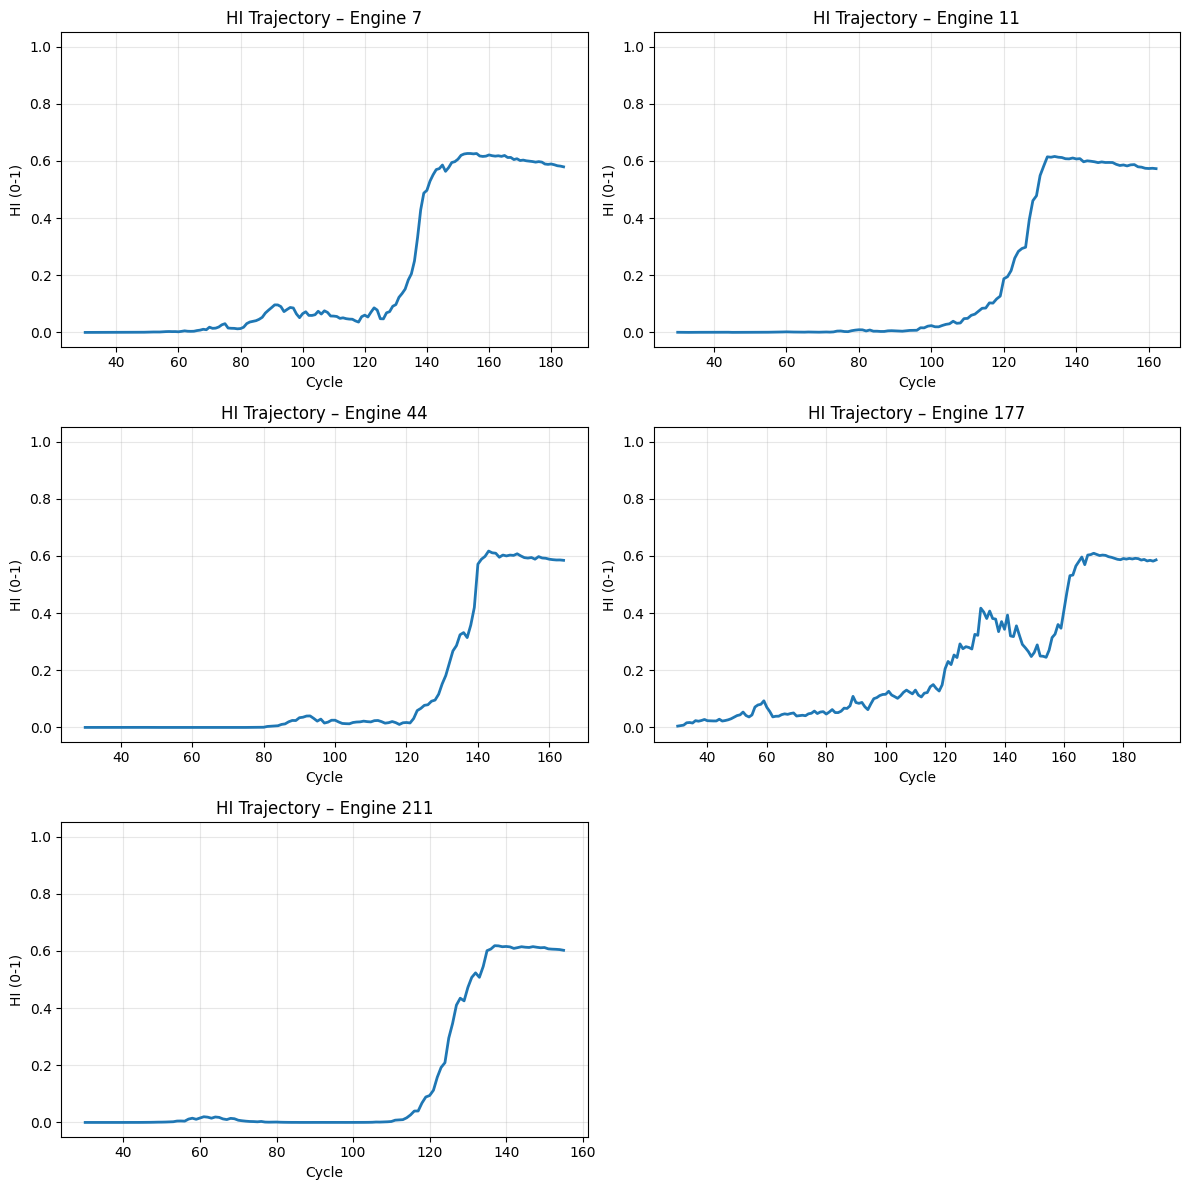

In [7]:
# Select degraded engines and plot HI trajectories
selected_ids = select_degraded_engines(eol_metrics, k=5)
print("Selected degraded engines:", selected_ids)
plot_hi_trajectories(selected_ids, trajectories, title_prefix="HI Trajectory")

